In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt  
import matplotlib.mlab as mlab    
import matplotlib as mpl  
from sklearn.model_selection import GridSearchCV
import datetime
import seaborn as sns

In [2]:
bill_amount = pd.read_csv('bill_amount.csv')
bill_id = pd.read_csv('bill_id.csv')
clinical_data = pd.read_csv('clinical_data.csv')
demographics = pd.read_csv('demographics.csv')

print bill_amount.shape
print bill_id.shape
print clinical_data.shape
print demographics.shape

(13600, 2)
(13600, 3)
(3400, 26)
(3000, 5)


In [3]:
len(clinical_data.id.unique())

3000

## 2. Data Cleaning & Pre-processing

### 2.1 Table: bill_amount
#### Step1: Convert data type

In [4]:
print bill_amount.dtypes
bill_amount.head()

bill_id      int64
amount     float64
dtype: object


,bill_id,amount
0,40315104,1552.634830
1,2660045161,1032.011951
2,1148334643,6469.605351
3,3818426276,755.965425
4,9833541918,897.347816


In [5]:
category_vars = ['bill_id']
numeric_vars = ['amount']

In [6]:
for var in category_vars:
    bill_amount[var] = bill_amount[var].astype(object)

In [7]:
for var in numeric_vars:
    bill_amount[var] = bill_amount[var].astype(float)

### 2.2 Table: bill_id
#### Step1: Convert data type

In [8]:
print bill_id.dtypes
bill_id.head()

bill_id               int64
patient_id           object
date_of_admission    object
dtype: object


,bill_id,patient_id,date_of_admission
0,7968360812,1d21f2be18683991eb93d182d6b2d220,2011-01-01
1,6180579974,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01
3,3762633379,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
4,7654730355,1d21f2be18683991eb93d182d6b2d220,2011-01-01


In [9]:
category_vars = ['bill_id', 'patient_id']
date_vars = ['date_of_admission']

In [10]:
for var in category_vars:
    bill_id[var] = bill_id[var].astype(object)

In [11]:
for var in date_vars:
    bill_id[var] = pd.to_datetime(bill_id[var])

### 2.3 Table: clinical_data

#### Step 1: Remove Anomalies

In [13]:
clinical_data['medical_history_3'].value_counts()

0      2176
No      761
1       348
Yes     115
Name: medical_history_3, dtype: int64

In [14]:
clinical_data['medical_history_3'] = np.where((clinical_data['medical_history_3'] == 'Yes') | (clinical_data['medical_history_3'] == '1') | (clinical_data['medical_history_3'] == 1), 1, 0)

In [15]:
clinical_data['medical_history_3'].value_counts()

0    2937
1     463
Name: medical_history_3, dtype: int64

#### Step 2: Handle missing values

In [17]:
def impute(var):
    ids = clinical_data.loc[clinical_data[var].isnull(),'id']
    for i in ids:
        tmp_value = clinical_data.loc[clinical_data.id == i, var].max()
        clinical_data.loc[clinical_data.id == i, var] = tmp_value

In [18]:
impute('medical_history_2')   
impute('medical_history_5')

In [19]:
print clinical_data[clinical_data['medical_history_2'].isnull()].shape
print clinical_data[clinical_data['medical_history_5'].isnull()].shape
#print clinical_data['medical_history_2'].value_counts()
#print clinical_data['medical_history_5'].value_counts()

(180, 26)
(238, 26)


In [20]:
clinical_data.dropna(axis=0, how='any', inplace = True)
print clinical_data.shape

(3009, 26)


#### Step3: Convert Data type

In [12]:
print clinical_data.dtypes
clinical_data.head()

id                     object
date_of_admission      object
date_of_discharge      object
medical_history_1       int64
medical_history_2     float64
medical_history_3      object
medical_history_4       int64
medical_history_5     float64
medical_history_6       int64
medical_history_7       int64
preop_medication_1      int64
preop_medication_2      int64
preop_medication_3      int64
preop_medication_4      int64
preop_medication_5      int64
preop_medication_6      int64
symptom_1               int64
symptom_2               int64
symptom_3               int64
symptom_4               int64
symptom_5               int64
lab_result_1          float64
lab_result_2          float64
lab_result_3          float64
weight                float64
height                float64
dtype: object


,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,...,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,...,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,...,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,...,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1.0,No,0,0.0,1,1,...,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0.0,No,0,0.0,1,1,...,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0


In [21]:
date_vars = ['date_of_admission', 'date_of_discharge']
bool_vars = ['medical_history_1', 'medical_history_2','medical_history_3', 'medical_history_4', 'medical_history_5', 'medical_history_6', 'medical_history_7', 'preop_medication_1', 'preop_medication_2', 'preop_medication_3', 'preop_medication_4', 'preop_medication_5', 'preop_medication_6', 'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5']
numeric_vars = ['lab_result_1', 'lab_result_2', 'lab_result_3', 'weight', 'height']

In [22]:
for var in date_vars:
    clinical_data[var] = pd.to_datetime(clinical_data[var])

In [23]:
for var in bool_vars:
    clinical_data[var] = clinical_data[var].astype(bool, errors = 'ignore')

In [25]:
for var in numeric_vars:
    clinical_data[var] = clinical_data[var].astype(float)

In [26]:
print clinical_data.dtypes
clinical_data.head()

id                            object
date_of_admission     datetime64[ns]
date_of_discharge     datetime64[ns]
medical_history_1               bool
medical_history_2               bool
medical_history_3               bool
medical_history_4               bool
medical_history_5               bool
medical_history_6               bool
medical_history_7               bool
preop_medication_1              bool
preop_medication_2              bool
preop_medication_3              bool
preop_medication_4              bool
preop_medication_5              bool
preop_medication_6              bool
symptom_1                       bool
symptom_2                       bool
symptom_3                       bool
symptom_4                       bool
symptom_5                       bool
lab_result_1                 float64
lab_result_2                 float64
lab_result_3                 float64
weight                       float64
height                       float64
dtype: object


,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,...,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,False,True,False,False,False,False,False,...,False,False,False,True,True,13.2,30.9,123.0,71.3,161.0
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,False,False,False,False,False,False,False,...,False,False,True,True,True,13.8,22.6,89.0,78.4,160.0
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,False,False,False,False,False,False,False,...,True,True,True,True,False,11.2,26.2,100.0,72.0,151.0
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,False,True,False,False,False,True,True,...,True,True,True,True,True,13.3,28.4,76.0,64.4,152.0
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,False,False,False,False,False,True,True,...,False,True,False,True,False,12.0,27.8,87.0,55.6,160.0


In [27]:
print clinical_data[clinical_data['medical_history_2'].isnull()].shape
print clinical_data[clinical_data['medical_history_5'].isnull()].shape

(0, 26)
(0, 26)


### 2.4 Table: demographic

In [28]:
print demographics.dtypes
demographics.head()

patient_id         object
gender             object
race               object
resident_status    object
date_of_birth      object
dtype: object


,patient_id,gender,race,resident_status,date_of_birth
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singaporean,1971-05-14
1,5b6477c5de78d0b138e3b0c18e21d0ae,f,Chinese,Singapore citizen,1976-02-18
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03
3,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15
4,541ad077cb4a0e64cc422673afe28aef,m,Chinese,Singaporean,1970-12-12


#### Step1: Remove anomalies

In [29]:
demographics.gender.value_counts()

Female    1396
Male      1333
m          170
f          101
Name: gender, dtype: int64

In [30]:
demographics['gender'] = np.where((demographics['gender'] == 'm') | (demographics['gender'] == 'Male'), 1, 0).astype(bool)

In [31]:
demographics.gender.value_counts()

True     1503
False    1497
Name: gender, dtype: int64

In [32]:
demographics.race.value_counts()

Chinese    1608
Malay       629
chinese     307
Indian      195
Others      161
India       100
Name: race, dtype: int64

In [33]:
demographics['race'] = np.where((demographics['race'] == 'Chinese') | (demographics['race'] == 'chinese'), 'Chinese', demographics['race'])
demographics['race'] = np.where((demographics['race'] == 'Indian') | (demographics['race'] == 'India'), 'Indian', demographics['race'])

In [34]:
demographics.race.value_counts()

Chinese    1915
Malay       629
Indian      295
Others      161
Name: race, dtype: int64

In [35]:
demographics.resident_status.value_counts()

Singaporean          1782
Singapore citizen     610
PR                    465
Foreigner             143
Name: resident_status, dtype: int64

In [36]:
demographics['resident_status'] = np.where((demographics['resident_status'] == 'Singaporean') | (demographics['resident_status'] == 'Singapore citizen'), 'Singaporean', demographics['resident_status'])

In [37]:
demographics.resident_status.value_counts()

Singaporean    2392
PR              465
Foreigner       143
Name: resident_status, dtype: int64

#### Convert data type

In [38]:
category_vars = ['patient_id','race', 'resident_status']
date_vars = ['date_of_birth']

In [39]:
for var in date_vars:
    demographics[var] = pd.to_datetime(demographics[var])

In [40]:
for var in category_vars:
    demographics[var] = demographics[var].astype(object)

# Merge Dataset

#### Step1: Merge table 'bill_amount' and 'bill_id'

In [41]:
bills_info = bill_id.merge(bill_amount, on = 'bill_id', how = 'outer')
print bills_info.shape

(13600, 4)


#### Step2: Aggregate bill amounts based on 'patient_id' and 'date_of_admission'

In [42]:
bills = bills_info.groupby(['patient_id','date_of_admission']).sum().reset_index()
print bills.shape

(3400, 3)


#### Step3: Merge 'Clinical_data', 'demographic' and bill information

In [43]:
data = bills.merge(clinical_data, left_on = ['patient_id', 'date_of_admission'], right_on = ['id', 'date_of_admission'], how = 'right').merge(demographics, how = 'left', on = 'patient_id')
data.drop(labels='id', inplace = True, axis = 1)
print data.shape

(3009, 31)


In [44]:
data.columns

Index([u'patient_id', u'date_of_admission', u'amount', u'date_of_discharge',
       u'medical_history_1', u'medical_history_2', u'medical_history_3',
       u'medical_history_4', u'medical_history_5', u'medical_history_6',
       u'medical_history_7', u'preop_medication_1', u'preop_medication_2',
       u'preop_medication_3', u'preop_medication_4', u'preop_medication_5',
       u'preop_medication_6', u'symptom_1', u'symptom_2', u'symptom_3',
       u'symptom_4', u'symptom_5', u'lab_result_1', u'lab_result_2',
       u'lab_result_3', u'weight', u'height', u'gender', u'race',
       u'resident_status', u'date_of_birth'],
      dtype='object')

## Feature Engineering
#### Step1: Add new variables

In [45]:
data['age'] = ((data['date_of_discharge'] - data['date_of_birth']).dt.days / 365).astype(int)
data['BMI'] = data['weight'] / np.square(data['height']/100)
data['number_of_symptoms'] = data['symptom_1'].astype(int) + data['symptom_2'].astype(int) + data['symptom_3'].astype(int) + data['symptom_4'].astype(int) + data['symptom_5'].astype(int)
data['number_of_medical_histories'] = data['medical_history_1'].astype(int) + data['medical_history_2'].astype(int) + data['medical_history_3'].astype(int) + data['medical_history_4'].astype(int) + data['medical_history_5'].astype(int)+ data['medical_history_6'].astype(int)+ data['medical_history_7'].astype(int)
data['number_of_preop_medications'] = data['preop_medication_1'].astype(int) + data['preop_medication_2'].astype(int) + data['preop_medication_3'].astype(int) + data['preop_medication_4'].astype(int) + data['preop_medication_5'].astype(int)+ data['preop_medication_6'].astype(int)
data['length'] = (data['date_of_discharge'] - data['date_of_admission']).dt.days
data['year_of_admission'] = data['date_of_admission'].dt.year
data['month_of_admission'] = data['date_of_admission'].dt.month

In [46]:
def find_frequency(patient_id, admission_date):
    return data[(data.patient_id == patient_id) & (data.date_of_admission < admission_date)].shape[0]

In [47]:
def find_recency(patient_id, admission_date):
    if (find_frequency(patient_id, admission_date) > 1):
        last_date = data.loc[(data.patient_id == patient_id) & (data.date_of_admission < admission_date), 'date_of_admission'].max()
        return (admission_date - last_date).days
    else:
        return float('Inf')

In [48]:
data['frequency'] = data.apply(lambda row: find_frequency(row['patient_id'], row['date_of_admission']), axis = 1)
data['recency'] = data.apply(lambda row: find_recency(row['patient_id'], row['date_of_admission']), axis = 1)

#### Step2: Encode categorical variables

In [49]:
categorical_vars = ['race', 'resident_status']
for var in categorical_vars:
    values = list(data[var].unique())
    for value in values:
        var_name = var + "_" + value
        data[var_name] = np.where((data[var] == value), True, False)

#### Step3: Split dataset

In [50]:
rm_columns = [ 'patient_id','date_of_admission', 'date_of_discharge', 'race', 'resident_status', 'date_of_birth']
target = 'amount'

X_male = data.loc[data['gender'] == True, ~data.columns.isin(rm_columns + [target])]
y_male = data.loc[data['gender'] == True, target]
X_female = data.loc[data['gender'] == False, ~data.columns.isin(rm_columns + [target])]
y_female = data.loc[data['gender'] == False, target]

print X_male.shape
print y_male.shape
print X_female.shape
print y_female.shape

(1503, 41)
(1503L,)
(1506, 41)
(1506L,)


## Modelling

#### Step1: Check correlation between features

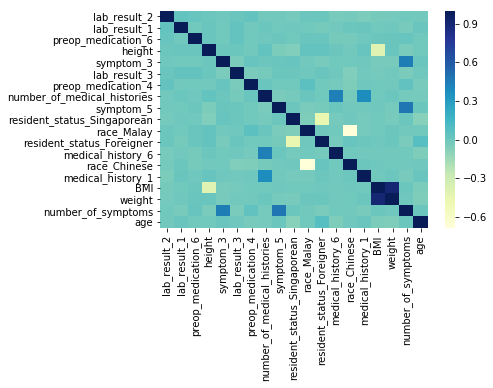

In [83]:
X_male.corr()
variable_correlations_m = X_male[label_m].corr()
sns.heatmap(variable_correlations_m, cmap='YlGnBu')
plt.show()

#### Step2.1: Model tunning(for male samples)

In [51]:
param_grid_lgb = {
          'num_leaves':[2**i for i in range(1,10)],
          'bagging_fraction' : [0.1*i for i in range(1,11)],
          'bagging_frequency' : range(1,6),
          'feature_fraction': [0.1*i for i in range(1,11)]}

In [54]:
regressor = lgb.LGBMRegressor(application = 'regression', 
                              num_threads = 2,
                              metric = 'rmse',
                             learnring_rate = 0.03)
search_lgb = GridSearchCV(regressor, param_grid_lgb, cv=5)


In [55]:
%time search_lgb.fit(X_male, y_male)

D:\abc\envs\python27true\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
D:\abc\envs\python27true\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


Wall time: 15min 23s


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMRegressor(application='regression', boosting_type='gbdt',
       colsample_bytree=1.0, learning_rate=0.1, learnring_rate=0.03,
       max_bin=255, max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=10,
       n_jobs=-1, num_leaves=31, num_threads=2, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'num_leaves': [2, 4, 8, 16, 32, 64, 128, 256, 512], 'feature_fraction': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0], 'bagging_fraction': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0], 'bagging_frequency': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scorin

In [56]:
search_lgb.best_params_

{'bagging_fraction': 1.0,
 'bagging_frequency': 1,
 'feature_fraction': 1.0,
 'num_leaves': 64}

#### Step2.2: train model (for male samples)

In [57]:
regressor_male = lgb.LGBMRegressor(application = 'regression', 
                              num_threads = 2,
                              metric = 'rmse',
                              bagging_fraction = 1.0,
                              feature_frequency = 1,
                              learnring_rate = 0.03,
                              num_leaves = 64)
                             
%time regressor_male.fit(X_male, y_male)


Wall time: 126 ms


LGBMRegressor(application='regression', bagging_fraction=1.0,
       boosting_type='gbdt', colsample_bytree=1.0, feature_frequency=1,
       learning_rate=0.1, learnring_rate=0.03, max_bin=255, max_depth=-1,
       metric='rmse', min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=10, n_jobs=-1, num_leaves=64,
       num_threads=2, objective=None, random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

#### Step2.3: Check the feature importance score (for male samples)

In [58]:
var_names_male = X_male.columns.values
var_importance_score_male = regressor_male.booster_.feature_importance()
var_importance_male = dict(zip(var_names_male, var_importance_score_male))
feature_importance_male = pd.DataFrame(sorted(var_importance_male.items(), key=lambda x: x[1]))
#feature_importance

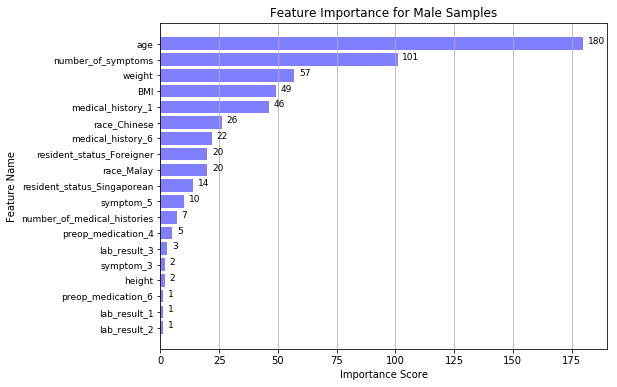

In [59]:
label_m = feature_importance_male[feature_importance_male[1] > 0][0].tolist()
x_m = feature_importance_male[feature_importance_male[1] > 0][1].tolist()
width = 0.8

plt.figure(figsize = (8,6))
idx = np.arange(0,len(x_m))
plt.barh(idx, x_m, width, color='blue', alpha=0.5)
for a,b in zip(x_m,idx):
    plt.text(a+2, b, a, fontsize=9)
plt.yticks(idx,label_m, fontsize = 9)
plt.xlim(0,190)
plt.grid(axis='x')

 
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance for Male Samples')
 
plt.show()

#### Step3.1 Model tunning (for female samples)

In [60]:
%time search_lgb.fit(X_female, y_female)

Wall time: 15min 46s


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMRegressor(application='regression', boosting_type='gbdt',
       colsample_bytree=1.0, learning_rate=0.1, learnring_rate=0.03,
       max_bin=255, max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=10,
       n_jobs=-1, num_leaves=31, num_threads=2, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'num_leaves': [2, 4, 8, 16, 32, 64, 128, 256, 512], 'feature_fraction': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0], 'bagging_fraction': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0], 'bagging_frequency': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scorin

In [61]:
search_lgb.best_params_

{'bagging_fraction': 1.0,
 'bagging_frequency': 1,
 'feature_fraction': 1.0,
 'num_leaves': 64}

#### Step3.2: Train Model (for female samples)

In [62]:
regressor_female = lgb.LGBMRegressor(application = 'regression', 
                              num_threads = 2,
                              metric = 'rmse',
                              bagging_fraction = 1.0,
                              feature_frequency = 1,
                              learnring_rate = 0.03,
                              num_leaves = 64)
                             
%time regressor_female.fit(X_female, y_female)


Wall time: 40 ms


LGBMRegressor(application='regression', bagging_fraction=1.0,
       boosting_type='gbdt', colsample_bytree=1.0, feature_frequency=1,
       learning_rate=0.1, learnring_rate=0.03, max_bin=255, max_depth=-1,
       metric='rmse', min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=10, n_jobs=-1, num_leaves=64,
       num_threads=2, objective=None, random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

#### Step3.3: Check Feature Importance (for female samples)

In [63]:
var_names_female = X_female.columns.values
var_importance_score_female = regressor_female.booster_.feature_importance()
var_importance_female = dict(zip(var_names_female, var_importance_score_female))
feature_importance_female = pd.DataFrame(sorted(var_importance_female.items(), key=lambda x: x[1]))
#feature_importance

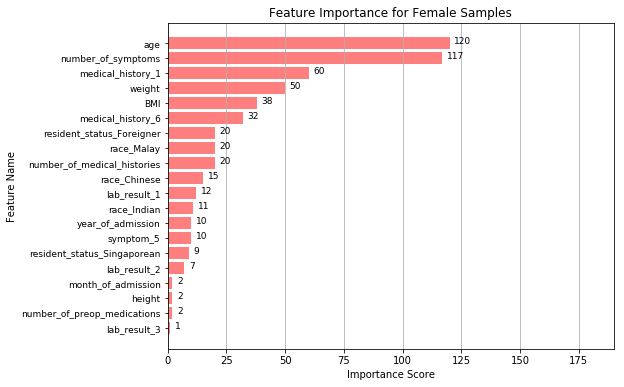

In [64]:
label_f = feature_importance_female[feature_importance_female[1] > 0][0].tolist()
x_f = feature_importance_female[feature_importance_female[1] > 0][1].tolist()
width = 0.8

plt.figure(figsize = (8,6))
idx = np.arange(0,len(x_f))
plt.barh(idx, x_f, width, color='red', alpha=0.5)
for a,b in zip(x_f,idx):
    plt.text(a+2, b, a, fontsize= 9)
plt.yticks(idx,label_f, fontsize = 9)
plt.xlim(0,190)
plt.grid(axis='x')

 
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance for Female Samples')
 
plt.show()

## Data Visualization

### Factor1: Age vs. Expense

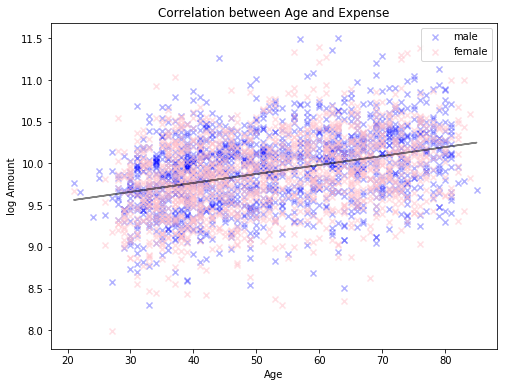

In [66]:
male = data.loc[data['gender'] == True, ['age', 'amount']].as_matrix()
female = data.loc[data['gender'] == False, ['age', 'amount']].as_matrix()

x = data['age'].tolist()
y = data['amount'].tolist()
z = np.polyfit(x, np.log(y), 1)
p = np.poly1d(z)


plt.figure(figsize=(8,6))
 
plt.scatter(male[:,0], np.log(male[:,1]), marker='x',
            color='blue', alpha=0.3, label='male')
plt.scatter(female[:,0], np.log(female[:,1]), marker='x',
            color='pink', alpha=0.5, label='female')

plt.plot(x, p(x),'r-', color = 'black', alpha = 0.5)


plt.title('Correlation between Age and Expense')
plt.ylabel('log Amount')
plt.xlabel('Age')
plt.legend(loc='upper right')
 
plt.show()


### Factor2: Sympton vs. Expense

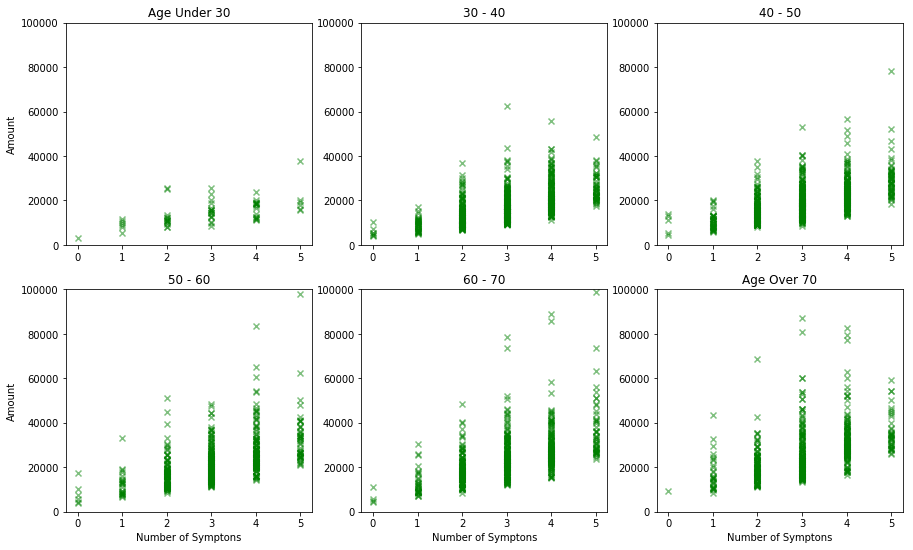

In [67]:
age_group1 = data.loc[data['age'] < 30, ['number_of_symptoms', 'amount']].as_matrix()
age_group2 = data.loc[(data['age'] >= 30) & (data['age'] < 40), ['number_of_symptoms', 'amount']].as_matrix()
age_group3 = data.loc[(data['age'] >= 40) & (data['age'] < 50), ['number_of_symptoms', 'amount']].as_matrix()
age_group4 = data.loc[(data['age'] >= 50) & (data['age'] < 60), ['number_of_symptoms', 'amount']].as_matrix()
age_group5 = data.loc[(data['age'] >= 60) & (data['age'] < 70), ['number_of_symptoms', 'amount']].as_matrix()
age_group6 = data.loc[ data['age'] >= 70, ['number_of_symptoms', 'amount']].as_matrix()

plt.figure(figsize=(15,9))
#plt.figure(figsize=(8,6))

plt.subplot(231) 
plt.scatter(age_group1[:,0], age_group1[:,1], marker='x',
            color='green', alpha=0.5)
plt.ylim(0, 100000) 
plt.title('Age Under 30')
plt.ylabel('Amount')
#plt.xlabel('Number of Symptons')

plt.subplot(232) 
plt.scatter(age_group2[:,0], age_group2[:,1], marker='x',
            color='green', alpha=0.5)
plt.title('30 - 40')
plt.ylim(0, 100000) 
#plt.ylabel('Amount')
#plt.xlabel('Number of Symptons')

plt.subplot(233) 
plt.scatter(age_group3[:,0], age_group3[:,1], marker='x',
            color='green', alpha=0.5)
plt.title('40 - 50')
plt.ylim(0, 100000) 
#plt.ylabel('Amount')
#plt.xlabel('Number of Symptons')

plt.subplot(234) 
plt.scatter(age_group4[:,0], age_group4[:,1], marker='x',
            color='green', alpha=0.5)
plt.title('50 - 60')
plt.ylabel('Amount')
plt.ylim(0, 100000) 
plt.xlabel('Number of Symptons')

plt.subplot(235) 
plt.scatter(age_group5[:,0], age_group5[:,1], marker='x',
            color='green', alpha=0.5)
plt.title('60 - 70')
plt.ylim(0, 100000) 
#plt.ylabel('Amount')
plt.xlabel('Number of Symptons')

plt.subplot(236) 
plt.scatter(age_group6[:,0], age_group6[:,1], marker='x',
            color='green', alpha=0.5)
plt.title('Age Over 70')
plt.ylim(0, 100000) 
#plt.ylabel('Amount')
plt.xlabel('Number of Symptons')



plt.show()


## Factor3: Weight & Height

In [71]:
male_health = data.loc[data['gender'] == True, ['height', 'weight', 'amount']]
female_health = data.loc[data['gender'] == False, ['height', 'weight', 'amount']]

In [72]:
min_value = 55
max_value = 125
interval = (max_value - min_value)/10
var = 'weight'

points = range(min_value, max_value, interval)
idx = 0
while (idx < len(points)):
    male_health.loc[male_health[var] >= points[idx], var + '_group'] = points[idx]
    idx = idx + 1

In [73]:
min_value = 160
max_value = 190
interval = (max_value - min_value)/10
var = 'height'

points = range(min_value, max_value, interval)
idx = 0
while (idx < len(points)):
    male_health.loc[male_health[var] >= points[idx], var + '_group'] = points[idx]
    idx = idx + 1

In [74]:
vis_data_male = male_health.pivot_table(values = 'amount', index = ['height_group'], columns = ['weight_group'], aggfunc = np.mean)
rows =[vis_data_male.index.tolist()[8-i] for i in range(0,9)]
vis_data_male = vis_data_male.ix[rows,:]
vis_data_male

D:\abc\envs\python27true\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


weight_group,55.0,62.0,69.0,76.0,83.0,90.0,97.0,104.0,111.0,118.0
height_group,,,,,,,,,,
184.0,NaN,NaN,NaN,25646.992653,NaN,NaN,NaN,NaN,NaN,NaN
181.0,NaN,10184.919987,21886.226061,31634.731324,23260.450048,15504.332064,14183.065483,NaN,NaN,NaN
178.0,NaN,13434.375998,22859.851004,20016.365069,21869.705116,22907.316465,29001.026229,22445.565449,25263.762496,NaN
175.0,23071.094345,20077.253015,24114.640133,23531.978022,21784.960401,22043.656609,28667.234922,NaN,NaN,NaN
172.0,20583.414594,25121.717437,22593.456385,20759.870670,22126.217146,22409.946620,27220.286370,27092.278902,26510.941973,17157.894701
169.0,14304.901394,17863.446849,20423.487648,22422.843711,23366.263018,25335.116499,25050.442486,23640.249087,14132.344208,NaN
166.0,23098.496667,19764.735569,19771.259019,22809.107001,21635.987522,24182.155763,20614.661826,21823.909166,28214.755847,NaN
163.0,26468.076708,20541.057816,17592.158684,25108.220733,23618.407829,24705.575976,25243.466715,36265.540055,NaN,NaN
160.0,16283.836039,23448.930790,19118.188410,24031.636248,24304.149609,20050.317210,26869.655604,22392.321806,NaN,NaN


In [75]:
min_value = 45
max_value = 115
interval = (max_value - min_value)/10
var = 'weight'

points = range(min_value, max_value, interval)
idx = 0
while (idx < len(points)):
    female_health.loc[female_health[var] >= points[idx], var + '_group'] = points[idx]
    idx = idx + 1

In [76]:
min_value = 150
max_value = 175
interval = (max_value - min_value)/10
var = 'height'

points = range(min_value, max_value, interval)
idx = 0
while (idx < len(points)):
    female_health.loc[female_health[var] >= points[idx], var + '_group'] = points[idx]
    idx = idx + 1

In [77]:
vis_data_female = female_health.pivot_table(values = 'amount', index = ['height_group'], columns = ['weight_group'], aggfunc = np.mean)
rows =[vis_data_female.index.tolist()[8-i] for i in range(0,9)]
vis_data_female = vis_data_female.ix[rows,:]
vis_data_female

D:\abc\envs\python27true\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


weight_group,45.0,52.0,59.0,66.0,73.0,80.0,87.0,94.0,101.0,108.0
height_group,,,,,,,,,,
166.0,31848.109318,11344.184164,20745.288745,23235.403071,20499.056410,22503.171898,22522.724274,NaN,20353.895459,NaN
164.0,10115.320643,14670.529350,18239.807822,19279.254586,22717.213319,20904.553032,19528.628357,24682.674775,NaN,NaN
162.0,16144.588188,17050.218320,21136.318027,18511.460780,21109.845205,21804.208724,24175.526090,13983.837320,NaN,NaN
160.0,13442.003033,17351.581529,20988.584281,18659.644740,23048.675088,21694.737807,21692.594594,28496.496375,NaN,NaN
158.0,24983.084808,15306.712755,23701.537720,21258.307290,25055.313796,21559.620704,28194.827703,24824.345813,NaN,16824.376406
156.0,20517.766300,18944.123491,17458.334917,21092.065177,22867.242473,24218.009007,21653.416278,30361.615205,23502.343871,25362.141396
154.0,NaN,18714.455430,19075.636602,20001.998017,21941.479175,25371.981145,27552.348541,38844.121424,NaN,19160.034143
152.0,31528.294364,17031.061418,18308.458989,16285.753436,17650.648261,22479.063991,28042.992680,33406.859510,NaN,NaN
150.0,NaN,17428.901026,20745.008741,18818.360465,24143.595066,21255.732588,29895.042784,25135.426045,24653.777171,NaN


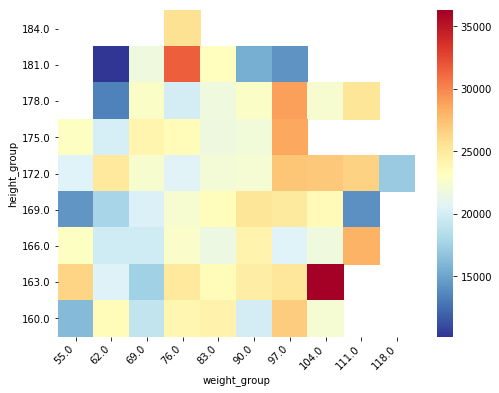

In [78]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(vis_data_male, ax=ax, cmap='RdYlBu_r')
label_y = ax.get_yticklabels()
plt.setp(label_y, rotation=0, horizontalalignment='right')
label_x = ax.get_xticklabels()
plt.setp(label_x, rotation=45, horizontalalignment='right')
plt.show()

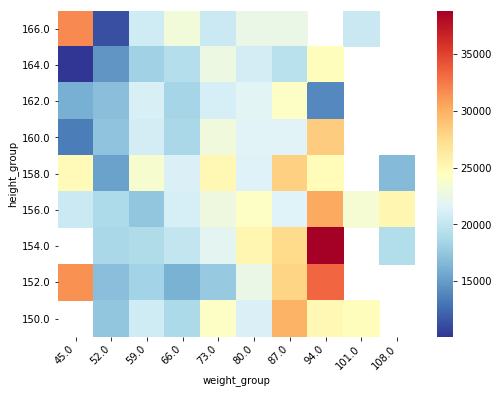

In [79]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(vis_data_female, ax=ax, cmap='RdYlBu_r')
label_y = ax.get_yticklabels()
plt.setp(label_y, rotation=0, horizontalalignment='right')
label_x = ax.get_xticklabels()
plt.setp(label_x, rotation=45, horizontalalignment='right')
plt.show()